## Solar mean prediction
We develop in this notebook a Markov Switching Auto-Regressive (MSAR) Model that predicts, based on past information, the mean value of the solar power over a defined number of minutes into the future.

In [1]:
#Importing modules that willbe used
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime
from io import BytesIO
import requests
import statsmodels.api as sm


import numpy as np,  pandas as pd, csv, random
import matplotlib.pyplot as plt
import sys

C:\Users\jprince\Anaconda3\envs\tf\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Define functions that are used in the notebook

In [2]:
def build_transitionMatrix_names(statesName_f):
    """Compute the transition Matrix name based on the input
    
    Inputs:
    -------
    statesName_f : String  
        MC states names
        Ex: ['Reg1','Reg2']
        
        
    outputs:
    --------
    [ ] : list
      Transition Matrix Name 
      Ex: [['Reg00', 'Reg01'], 
           ['Reg10', 'Reg11']]
    """
    idtf = statesName_f[0][:len(statesName_f[0])-1] # Get the identifier of the state, Ex: 'Reg'
    var_len = len(statesName_f)                     # Get the MC total number of states (regimes)

    tranMat_names = [] #List to store all the regime's (states) names. Each element in the list  
                       # corresponds to a row of the transition Matrix name


    for lines in range(var_len):
        tranMat_names_row = []

        for colls in range(var_len):
            # Add the identifier to the line and column to create the state's name
            names_row = idtf+str(lines)+str(colls)
            tranMat_names_row.append(names_row)
            
        tranMat_names.append(tranMat_names_row)
        
    return tranMat_names




def build_MC_states(nb_states, nb_step, transitionMatrix_f, start_state_f='Reg0'):
    """Run the dynamic evolution of a MC with `nb_states` based on the 
         transition probability matrix given by `transitionMatrix_f`
    
    Inputs:
    -------
    nb_states : int
        Number of regimes or states defining the MC
        
    nb_step: Int 
        number of step of simulation
        
    transitionMatrix_f :Array 
        Transition matrix probability.
        
    start_state: String 
        Initial markov chain state
        
        
    outputs: 
    -------
    state_intName_list : List 
        List of the the integer identifier of the regimes (states) that the MC has visited at each step
        
    """

    start_state_int = int(start_state_f[-1]) # get the integer identifier of the initial state
    state_intName_list = [start_state_int]   # Add the integer identifier of the initial state to the list that 
                                             # store the integer identifier of all the states visited by the MC 

    
    for i in range(1,nb_step):# for each step
        
        # Choose randomly the next state based on the transition matrix row associated with the current state
        next_state = np.random.choice(range(nb_states),p=transitionMatrix_f[state_intName_list[-1]])
        state_intName_list.append(next_state)# add next state to the list

    return state_intName_list





def MSAR_mod_pred(stateNamesInt_list_f, params_mod, yt_minus, prev_reg=[0,0], start_day_f='2019-07-21 00:00',Freq='1T'):
    """Predict the future Solar production based on the inputs
    
    Inputs:
    -------
    nb_states: list or 1D array
        List of the different state that the MC has visited based on 
        the transition matrix. Output of the function build_MC_states(args)
        
    params_mod: dict
        Dictionary containing all the MSAR's model parameters 
        
    yt_minus: 1D array
        Array containing the past values of the variable to predict onto the future.
        Note that: 
              if len(yt_minus) = number of lags, supposing the initial instant is k 
                        P_pred(k)   = f( P_real(k-1),(P_real(k-2) )
                        P_pred(k+1) = f( P_pred(k),  (P_real(k-1) ),
                        P_pred(k+2) = f( P_pred(k+1),(P_pred(k)   )
                    i.e. the prediction from time k+2 to ... K  is function of predicted values. 
              if len(yt_minus) = nb_states, 
                        P_pred(k)   = f( P_real(k-1),(P_real(k-2) ), 
                        P_pred(k+1) = f( P_real(k),(P_real(k-1)   ), 
                        P_pred(k+2) = f( P_real(k+1),(P_real(k)   ) 
                    i.e. the prediction from time k+2 to ... K 
        
    prev_reg: 1D array
        Array containing the previous regime of the Markov Chain (MC).
        Its size equals the number of lag in the MSAR model. 
        Ex: Two lags ==> yt_minus = [0, 0]
           
    start_day_f: String date 
        The starting instant of the predicted vector.
        Ex: '2019-07-21 00:00'
        
    Freq: String time frequency 
       The frequency of the predicted values.
       Ex: '1T'
        
   
    outputs: 
    -------
    out : pd.series() 
        A pd.series object starting at start_day_f with prequency Freq and 
        the length of stateNamesInt_list_f
        
    """
    # Get the number of states visited by the MSAR model       
    var0 = len(stateNamesInt_list_f)+2  
    
    #instanciate output data 
    yy = np.zeros(var0)
    
    # Markov chain regimes
    mc_regime = np.zeros(var0)
    
    #Error parameters
    μ_err = params_mod['Err']['mean']
    σ_err =  params_mod['Err']['std'];
    
    #create epsilon output 
    eps = np.random.normal(loc= μ_err,scale=σ_err, size=var0 )
    
    #Filling the first two values of the output 
    yy[0:2] =yt_minus[0:2];
    
    mc_regime[0:2] = prev_reg ; # The first two regimes are given by prev_reg =[1,1]
    mc_regime[2:] = stateNamesInt_list_f # the remaining instants regime are given by stateNamesInt_list_f
    
    mc_regime = mc_regime.astype(int)  # Make sure the MC are integer
    
    for k in range(2,var0):
        
        # Define the regime name for the previous instant and the current one
        regime_km2 = 'Reg'+str(mc_regime[k-2])
        regime_km1 = 'Reg'+str(mc_regime[k-1])
        regime_k = 'Reg'+str(mc_regime[k])
        
        if len(yt_minus)==2: # At time k, to predict y(k) use the prediction  y(k-1), y(k-2) and y(k-3)
            ar1 = params_mod[regime_k]['θ1']*(yy[k-1] - params_mod[regime_km1]['θ0'])
            ar2 = params_mod[regime_k]['θ2']*(yy[k-2] - params_mod[regime_km2]['θ0']);
        else: # At time k, to predict y(k) use the real values  y(k-1) and y(k-2) and y(k-3)
            ar1 = params_mod[regime_k]['θ1']*(yt_minus[k-1] - params_mod[regime_km1]['θ0'])
            ar2 = params_mod[regime_k]['θ2']*(yt_minus[k-2] - params_mod[regime_km2]['θ0']);
            
        
        yy[k] = params_mod[regime_k]['θ0'] + ar1 + ar2 + eps[k] 
                
            
    return pd.Series(yy[2:],index=pd.date_range(start_day_f,freq=Freq,periods=var0-2))




#Funcion to delete duplicate on the input_list
def del_duplicate(input_list):
    out_list=[];
    [out_list.append(elm) for elm in input_list if elm not in out_list]
    return out_list


## Read files

In [4]:
# Import Pecan street data (Change the folder_name according to the location on the host machine )
folder_name = "../DataFiles/"
file_name = folder_name + "PecanStreet_1minute_data_newyork.csv"

#read 10^5 files in the files with important colums being ("dataid","localminute","grid")
data_csv = pd.read_csv(file_name,index_col=False, usecols= ["dataid","localminute","grid","car1","solar","solar2"],keep_default_na=False,nrows=5000000)

C:\Users\jprince\AppData\Local\Temp/ipykernel_18480/1569618376.py:6: DtypeWarning: Columns (67) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv(file_name,index_col=False, usecols= ["dataid","localminute","grid","car1","solar","solar2"],keep_default_na=False,nrows=5000000)


## Choose a random client, extract Pv and plot 

In [16]:
#cust_id = random.choice(del_duplicate(data_csv.dataid)); # select a random client 
cust_id = 387
data_custid = data_csv[data_csv.dataid==cust_id] # select all the data of that random client

cust_p_pv = 0   # variable to store the customer  P_pv
cust_p_ev = 0   # variable to store the customer  P_ev

# Select the days to extract from the random customer data
start_day = '2019-07-01'
end_day = '2019-07-21'
data_custid_day = data_custid[(start_day <= data_custid.localminute) & (data_custid.localminute < end_day)]

# Sort data in increasing order of time
data_custid_day = data_custid_day.sort_values(by='localminute');


data_custid_day2 = data_custid_day;
data_custid_day2.index = pd.date_range(start_day ,freq='T',periods=len(data_custid_day))

# Get rid of useless collum 
data_custid_day.drop(labels=['dataid','localminute'], axis=1,inplace=True)

# #Replace '' by O
data_custid_day2 = data_custid_day2.replace('', 0.)

# extract PV_data 
cust_p_pv =  data_custid_day[['solar','solar2']].sum(axis=1)

### Plot  pv production for the training set

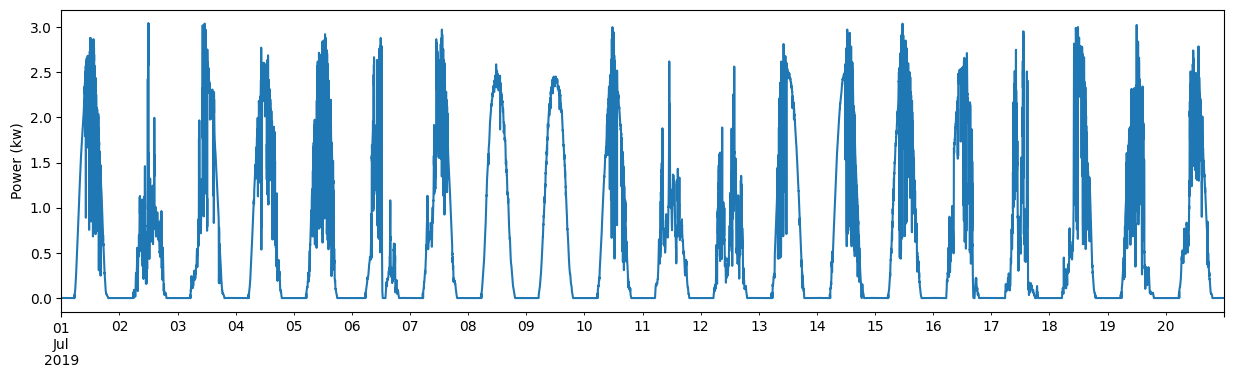

In [17]:
total_traning_set =  cust_p_pv.abs()# 
plt.figure(figsize=(15,4), dpi = 100)
total_traning_set.plot();
plt.ylabel('Power (kw)');

## Resample training set

In [18]:
res_freq = 15 # Resampling frequency
res_freq_str = str(res_freq)+'T' # Create a string based on the resampling frequency

# Resample training set by taking it mean
resample_train_set_mean = total_traning_set.resample(res_freq_str, label='right').mean()


### Create the daylight training set (04:30 a.m to 07:30 p.m)

In [19]:
# Extract the daylight period for the first day of the training set
daylight_train_set = resample_train_set_mean[(resample_train_set_mean.index>='2019-07-01 04:30') & (resample_train_set_mean.index<='2019-07-01 19:30')];


for i in range(2,21): # For the remaining days in the training set:
    start_timeFrame = '2019-07-'+ str(i).zfill(2)+ ' 04:30'
    end_timeFrame =   '2019-07-'+ str(i).zfill(2)+ ' 19:30'
    
    # Extract daylight period for the new day defined by start_timeFrame and end_timeFrame
    new_day = resample_train_set_mean[(resample_train_set_mean.index>=start_timeFrame) & (resample_train_set_mean.index<=end_timeFrame) ]
    
    # add daylight period of the new day to the previous ones 
    daylight_train_set = pd.concat([daylight_train_set,new_day])



### Normalize and plot

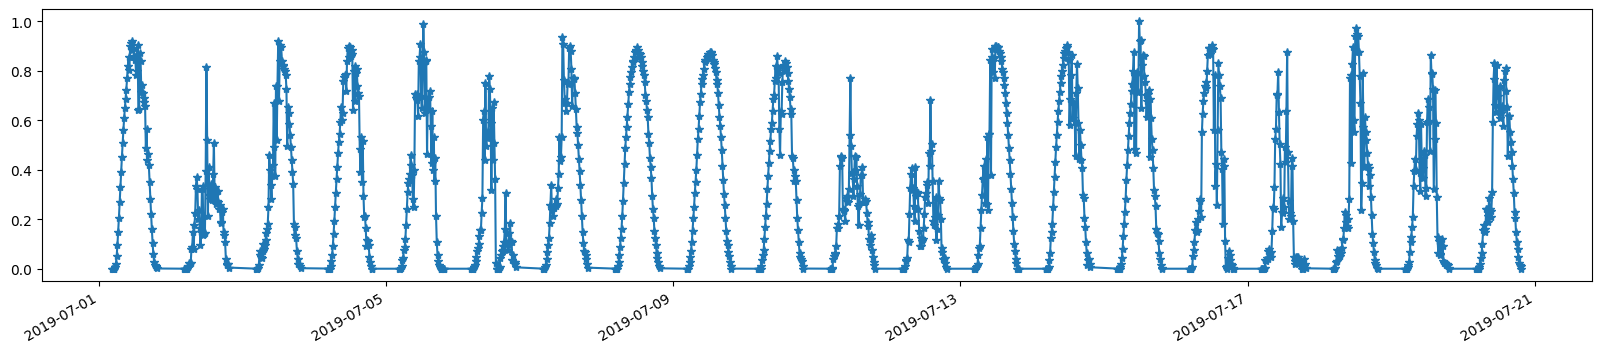

In [20]:
daylight_train_set_norm = daylight_train_set/daylight_train_set.max()
plt.figure(figsize=(20,4), dpi = 100)
daylight_train_set_norm.plot(marker='*');

# MSAR equation
Using an autoregressive model of order two (2 lags) with the constant coefficients given by $\theta_1, \theta_2$ and where the mean of the process $\theta_0$ switches between two regimes.  

## $\tilde{Y}_{(k)} =  \theta_0^{_{r(k)}} +  \theta_1 \left (  Y_{(k-1)} - \theta_0^{_{r(k-1)}} \right ) + \theta_2 \left (  Y_{(k-2)} - \theta_0^{_{r(k-2)}} \right ) +  \xi_{(k)}, \forall r \in \{0,1\}$

## Create model

In [21]:
# Create a model
PvMod = sm.tsa.MarkovAutoregression(daylight_train_set_norm, k_regimes=2, order=2,switching_ar=False)

# Fit the model to the training set 
PvMSAR_mod = PvMod.fit()

# Extract fitted values 
fit_values = PvMSAR_mod.fittedvalues


C:\Users\jprince\Anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [22]:
# for jour in range(1,20):
#     start_timeFrame = '2019-07-'+ str(jour).zfill(2)+ ' 19:30'    
#     end_timeFrame = '2019-07-'+ str(jour+1).zfill(2)+ ' 04:30'
    
#     fit_values[(fit_values.index > start_timeFrame) & (fit_values.index < end_timeFrame) ] = 0
    

### Plot real and fitted data 

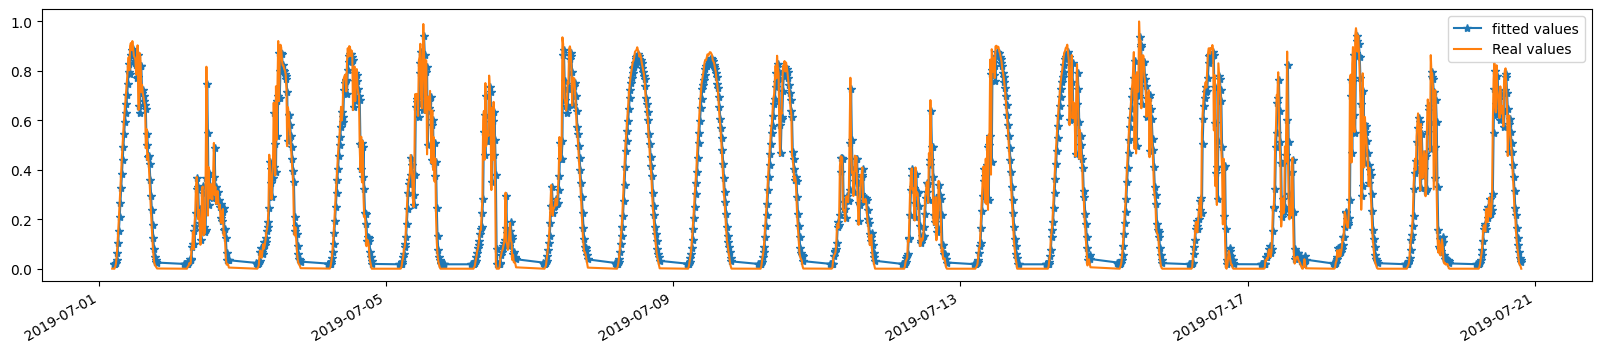

In [23]:
plt.figure(figsize=(20,4), dpi = 100)
fit_values.plot(label="fitted values", marker="*")
daylight_train_set_norm.plot(label="Real values")
plt.legend();

### $(CumSum)^2$ error between real and fitted data

<AxesSubplot:>

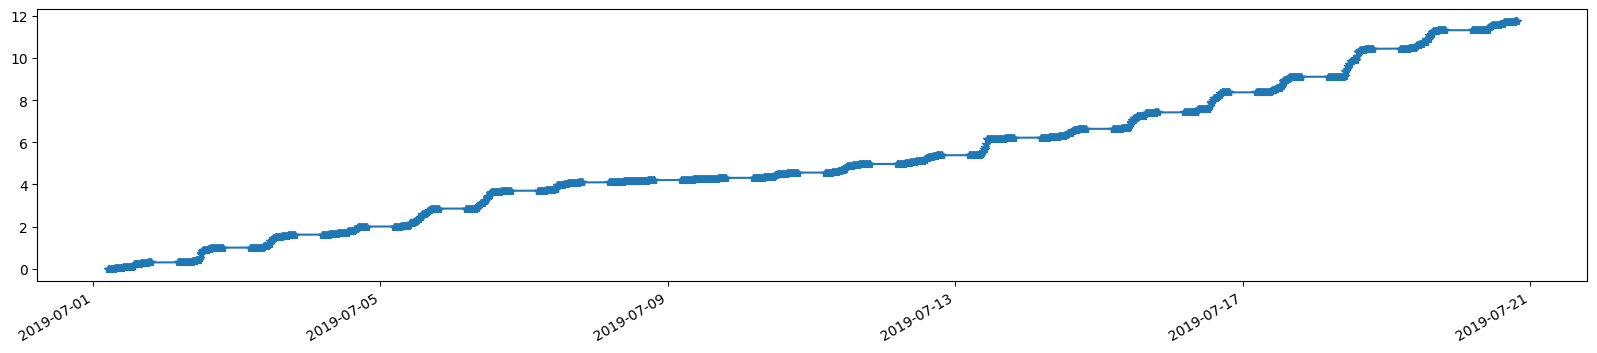

In [25]:
plt.figure(figsize=(20,4), dpi = 100)

Err =PvMSAR_mod.fittedvalues - daylight_train_set_norm
np.cumsum(Err**2).plot(marker='*' )


### Fitted model summary

In [26]:
PvMSAR_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                 1218
Model:             MarkovAutoregression   Log Likelihood                1097.504
Date:                  Wed, 18 May 2022   AIC                          -2181.007
Time:                          18:48:52   BIC                          -2145.273
Sample:                               0   HQIC                         -2167.556
                                 - 1218                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3623      0.044      8.191      0.000       0.276       0.449
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3676      0.067      5.517      0.000       0.237       0.498
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0096      0.000     22.441      0.000       0.009       0.010
ar.L1          0.8388      0.029     28.654      0.000       0.781       0.896
ar.L2          0.1122      0.029      3.850      0.000       0.055       0.169
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5000        nan        nan        nan         nan         nan
p[1->0]        0.4993        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Create a dict to store the fitted model data 

In [27]:
# Dictionary containing all the data of the 2 regimes MSAR
PvMSAR_mod_dict = {}
PvMSAR_mod_dict.update({"Reg0": {'θ0':0.3623  ,'θ1':0.8388	, 'θ2':0.1122} })
PvMSAR_mod_dict.update({"Reg1": {'θ0':0.3676  ,'θ1':0.8388	, 'θ2':0.1122} })
PvMSAR_mod_dict.update({"Err": {'mean':0.0096, 'std':0.00e-06} })
PvMSAR_mod_dict

{'Reg0': {'θ0': 0.3623, 'θ1': 0.8388, 'θ2': 0.1122},
 'Reg1': {'θ0': 0.3676, 'θ1': 0.8388, 'θ2': 0.1122},
 'Err': {'mean': 0.0096, 'std': 0.0}}

In [28]:
# From Regime transition parameters
prb00 = 0.5
prb10= 0.4993

prb01 = 1 - prb00
prb11 = 1- prb10
statesName= ["Reg0","Reg1"]
# transitionNames = build_transitionMatrix_names(statesName)
transitionMatrix =[[prb00, prb01], [prb10, prb11]]

## Create a dynamic markov chain based on the model Regime transition parameters (2 regimes) for 11 days.

In [29]:
#Create a markov chain moving throughout the 2 regimes for 11 days.
nb_days = 11
nb_min = 1440/res_freq
total_timeStep = nb_days*int(nb_min)

# dmc: Dynamic Markov chain 
dmc_stateName_list = build_MC_states(len(statesName), total_timeStep, transitionMatrix,'Reg1')# Instanciante at regime 1


## Enforce the regime of the chain to be stable from 19:45PM - 4:15AM


In [30]:
# 6PM = 1080 mn and 6AM = 1080 + 720  
# 19:45PM = 1185 mn and 4:15 = 1185 + 510 (8h30*60) 

cur_day = 0

var_19h45 =  int(1185/res_freq)
var_24h = int(1440/res_freq)
var_4h15 = int(510/res_freq)

for jj in range(0,total_timeStep,int(nb_min)):
    
    
    if cur_day==0: # for the first day, from 0-4h15
        dmc_stateName_list[:var_4h15] = np.zeros(var_4h15).astype(int)
        
    if cur_day ==(nb_days-1): # for the last day of the data
        dmc_stateName_list[total_timeStep-var_4h15:] = np.zeros(var_4h15).astype(int)
    
    # for the days between
    if ((cur_day >=0) & (cur_day<=nb_days-1)):
        var1 = var_19h45 + (cur_day-1)*var_24h
        dmc_stateName_list[var1: var1 + var_4h15]  = np.zeros(var_4h15).astype(int)
        
    cur_day = cur_day+1

### Plot MC regimes for 10 days test set

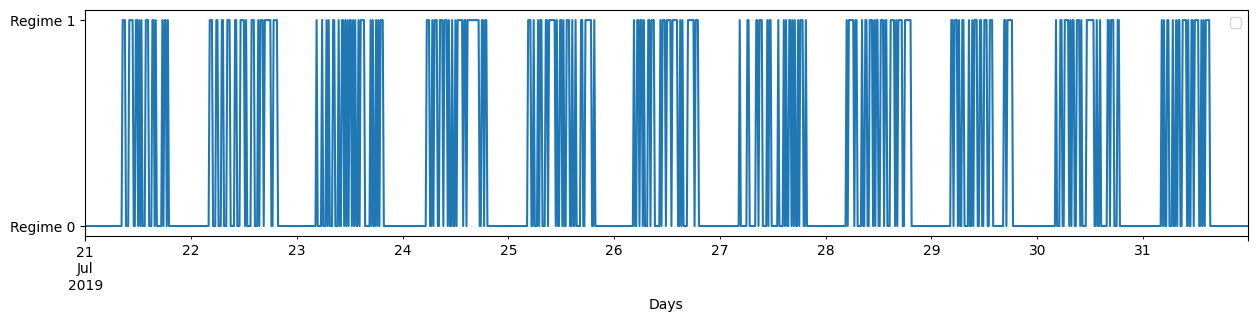

In [31]:
fig, axx = plt.subplots(1,figsize=(15,3), dpi=100)
pd.DataFrame(dmc_stateName_list,index=pd.date_range('2019-07-21 00:00',freq=res_freq_str,periods=nb_min*nb_days)).plot(ax=axx)
plt.legend([])
plt.xlabel('Days')
plt.yticks(range(0,2),labels=['Regime 0', 'Regime 1']);

## Extract real Pv Testing Set

In [32]:
cust_id = 387 
data_custid = data_csv[data_csv.dataid==cust_id] # select all the data of that random client
# Select daay 
start_day = '2019-07-20 22:45'
end_day = '2019-07-32'
data_custid_day = data_custid[(start_day <= data_custid.localminute) & (data_custid.localminute < end_day)]
data_custid_day = data_custid_day.sort_values(by='localminute');

#convert each column in float type
data_custid_day2 = data_custid_day;
data_custid_day2.index =pd.date_range(start_day ,freq='T',periods=len(data_custid_day))

# Get rid of useless collum 
data_custid_day.drop(labels=['dataid','localminute'], axis=1,inplace=True)

# #Replace '' by O
data_custid_day2 = data_custid_day2.replace('', 0.)

# COnvert all data in float type
for elm in data_custid_day2:
     data_custid_day2[elm] = np.array(data_custid_day2[elm],dtype=float)

# extract PV_data 
cust_p_pv =  data_custid_day2[['solar','solar2']].sum(axis=1)

total_test_set =  cust_p_pv.abs()

### Resample and normalize test set

In [33]:
resample_test_set = total_test_set.resample('15T',label='right').mean()

maxx = resample_test_set.max()
resample_test_set_norm = resample_test_set/maxx

In [39]:
resample_test_set_norm.iloc[2:]

2019-07-20 23:30:00    0.000768
2019-07-20 23:45:00    0.000768
2019-07-21 00:00:00    0.000768
2019-07-21 00:15:00    0.000768
2019-07-21 00:30:00    0.000768
                         ...   
2019-07-31 23:00:00    0.000768
2019-07-31 23:15:00    0.000768
2019-07-31 23:30:00    0.000768
2019-07-31 23:45:00    0.000768
2019-08-01 00:00:00    0.000768
Freq: 15T, Length: 1059, dtype: float64

## Predict values based on MSAR equation and the model parameters

In [41]:
pdct_ppv = MSAR_mod_pred(dmc_stateName_list,
                    PvMSAR_mod_dict,
                    resample_test_set_norm.iloc[2:], # make sure the input data start 2 period(lags) after the initial instant
                    prev_reg=[0,0],
                    start_day_f='2019-07-21 00:00',# First Predicted values at 00:00  predicted with two lags of the previous day 23:30 and 23:45
                    Freq=res_freq_str)

### Enforce the predicted values to equal 0 during th night

In [42]:
for jour in range(20,31):
    start_timeFrame = '2019-07-'+ str(jour).zfill(2)+ ' 19:00'    
    end_timeFrame = '2019-07-'+ str(jour+1).zfill(2)+ ' 04:30'
    
    pdct_ppv[(pdct_ppv.index > start_timeFrame) & (pdct_ppv.index < end_timeFrame) ] = 0
    
    if jour==30: 
        pdct_ppv[pdct_ppv.index > '2019-07-31 19:00'] = 0
    

### Plot predicted and real values

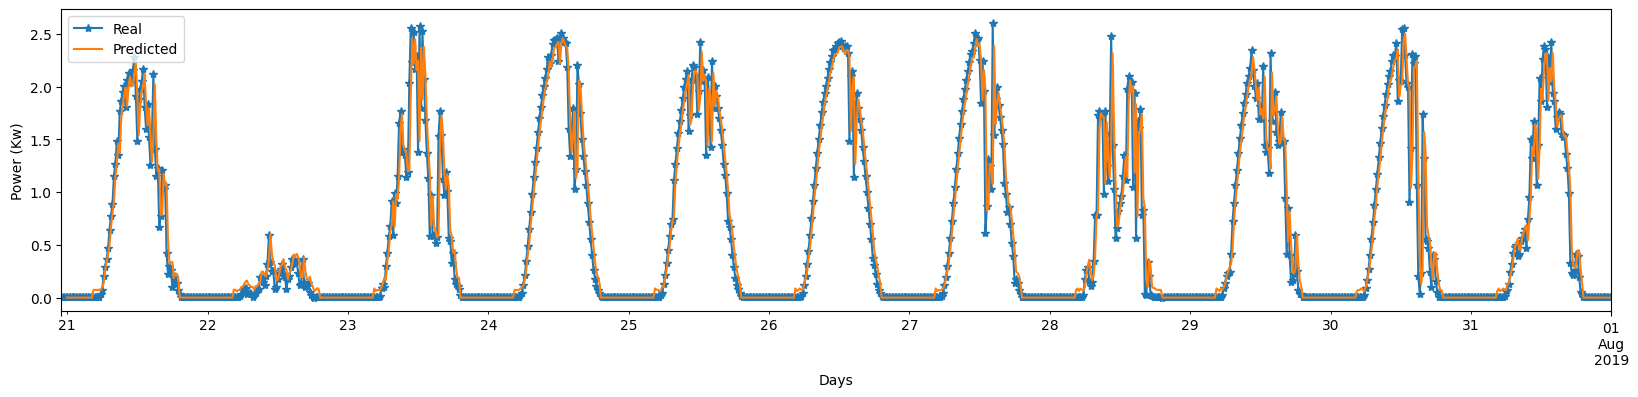

In [43]:
plt.figure(figsize=(20,4), dpi=100)

resample_test_set.plot(label="Real",marker='*')

#denormalized predicted values and plot
(pdct_ppv*maxx).plot(label='Predicted',ylabel='Power (Kw)',xlabel='Days' )

plt.legend();

### Plot error between the predicted and the real Pv

<AxesSubplot:xlabel='Days'>

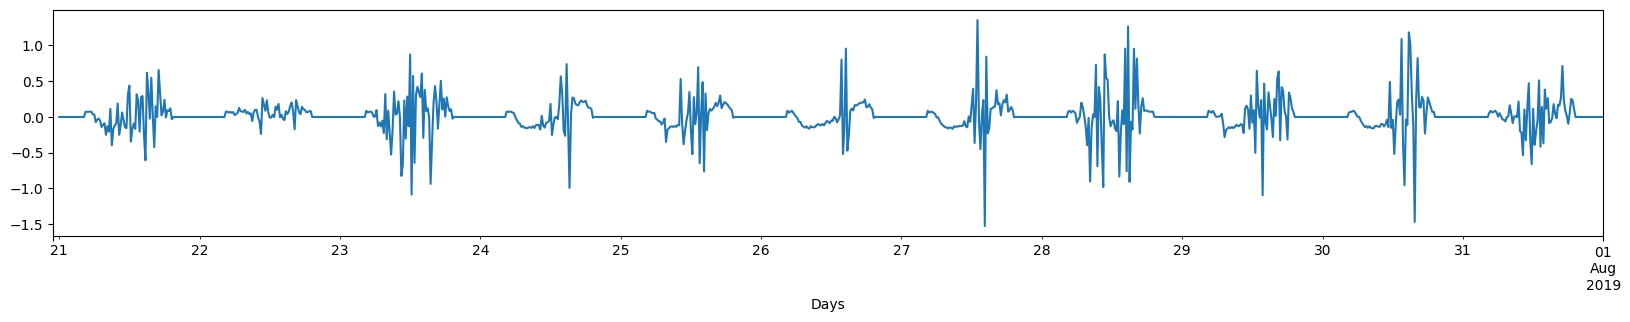

In [44]:
plt.figure(figsize=(20,3), dpi=100)
Err = (pdct_ppv*maxx) - resample_test_set
Err.plot(xlabel='Days')